In [1]:
import matplotlib.image as img
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, sin, cos
from bresenham import bresenham
from pydicom import dcmread

In [2]:
alfa = 2
n = 250
l = 0.5
steps = 10

In [3]:
# image = img.imread("tomograf-zdjecia/CT_ScoutView.jpg")

# plt.imshow(image, cmap="gray"))
# plt.show()

Patient's Name...: Doe, John
Patient ID.......: 42
Modality.........: CT
Image size.......: 1024 x 880


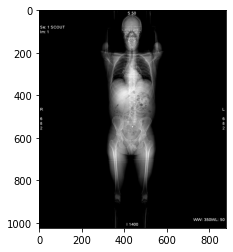

In [4]:
ds = dcmread("dicom_examples/CT_ScoutView.dcm")

pat_name = ds.PatientName
display_name = pat_name.family_name + ", " + pat_name.given_name
print(f"Patient's Name...: {display_name}")
if hasattr(ds, "PatientID"):
    print(f"Patient ID.......: {ds.PatientID}")
if hasattr(ds, "Modality"):
    print(f"Modality.........: {ds.Modality}")
if hasattr(ds, "StudyDate"):
    print(f"Study Date.......: {ds.StudyDate}")
if hasattr(ds, "Rows") and hasattr(ds, "Columns"):
    print(f"Image size.......: {ds.Rows} x {ds.Columns}")
if hasattr(ds, "PixelSpacing"):
    print(f"Pixel Spacing....: {ds.PixelSpacing}")

image = ds.pixel_array

plt.imshow(image, cmap="gray")
plt.show()

In [5]:
height = len(image)
width = len(image[0])

r = ((width ** 2 + height ** 2) ** (1 / 2)) / 2

In [6]:
def find_min_max(arr):
    max_value = 0
    min_value = 999999999
    for i in range(len(arr)):
        for j in arr[i]:
            if j < min_value:
                min_value = j
            if j > max_value:
                max_value = j
    return (min_value, max_value)

In [7]:
image_gray = np.zeros((height, width))
for i in range(width):
    for j in range(height):
        image_gray[j][i] = np.mean(image[j][i])

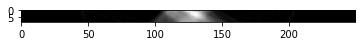

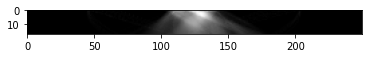

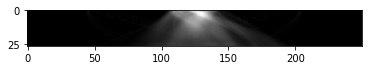

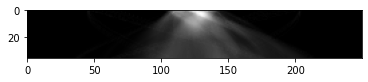

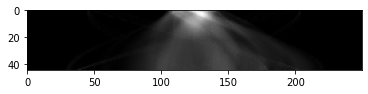

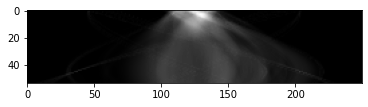

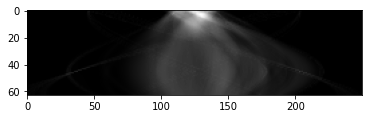

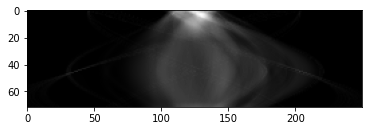

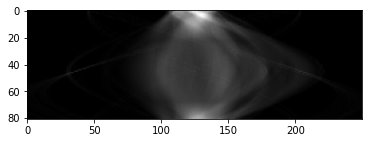

In [8]:
sinogram = []
pixel_number_in_line = np.zeros((height, width))
coords = []
for i in range(ceil(180 / alfa)):
    if i > 0 and i % (ceil(180 / alfa)/steps) == 0:
        min_value, max_value = find_min_max(sinogram)
        plt.imshow(sinogram, cmap="gray", vmin=min_value, vmax=max_value)
        plt.show()
    xCenter = r * sin(np.radians(i * alfa))
    yCenter = r * cos(np.radians(i * alfa))
    row_sinogram = []
    row_num = []
    row_coords = []
    for j in range(n):
        sum_sinogram = 0
        xE = r * sin(np.radians(i * alfa + (j - (n - 1) / 2) * l))
        yE = r * cos(np.radians(i * alfa + (j - (n - 1) / 2) * l))
        xD = round(xE - 2 * xCenter + width / 2)
        yD = round(yE - 2 * yCenter + height / 2)
        xE = round(xE + width / 2)
        yE = round(yE + height / 2)
        row_coords.append([xE, yE, xD, yD])
        for pixel in list(bresenham(xE, yE, xD, yD)):
            if 0 <= pixel[0] < width and 0 <= pixel[1] < height:
                sum_sinogram += image_gray[pixel[1]][pixel[0]]
                pixel_number_in_line[pixel[1]][pixel[0]] += 1
        row_sinogram.append(sum_sinogram)
    sinogram.append(row_sinogram)
    coords.append(row_coords)

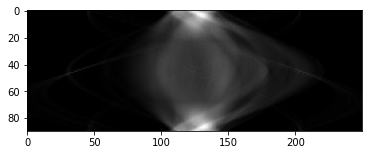

In [9]:
min_value, max_value = find_min_max(sinogram)
plt.imshow(sinogram, cmap="gray", vmin=min_value, vmax=max_value)
plt.show()

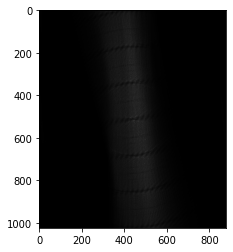

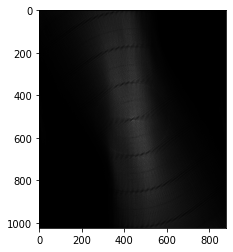

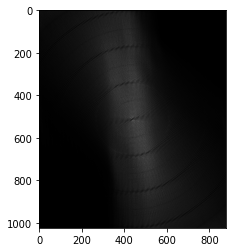

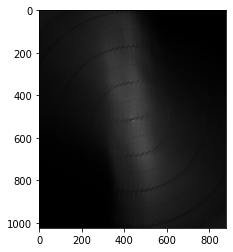

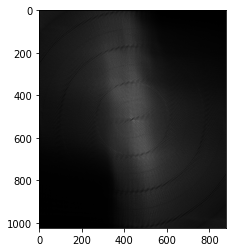

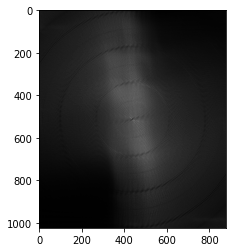

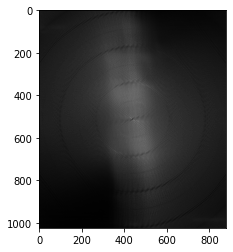

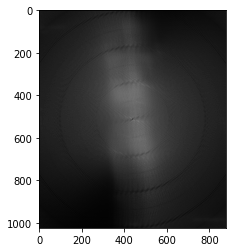

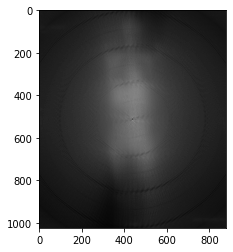

In [10]:
# recreating the image
new_image = np.zeros((height, width))
for i in range(ceil(180 / alfa)):
    if i > 0 and i % (ceil(180 / alfa)/steps) == 0:
        min_value, max_value = find_min_max(new_image)
        plt.imshow(new_image, cmap="gray", vmin=min_value, vmax=max_value)
        plt.show()
    for j in range(n):
        for pixel in list(
            bresenham(
                coords[i][j][0], coords[i][j][1], coords[i][j][2], coords[i][j][3]
            )
        ):
            if 0 <= pixel[0] < width and 0 <= pixel[1] < height:
                new_image[pixel[1]][pixel[0]] += (
                    sinogram[i][j] / pixel_number_in_line[pixel[1]][pixel[0]]
                )

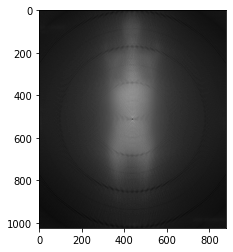

In [11]:
min_value, max_value = find_min_max(new_image)
plt.imshow(new_image, cmap="gray", vmin=min_value, vmax=max_value)
plt.show()

In [12]:
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids

from skimage.util import img_as_ubyte
from skimage.exposure import rescale_intensity

def convert_image_to_ubyte(img):
    return img_as_ubyte(rescale_intensity(img, out_range=(0.0, 1.0)))

def save_as_dicom(file_name, img, patient_data):
    img_converted = convert_image_to_ubyte(img)
    
    # Populate required values for file meta information
    meta = Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  

    ds = FileDataset(None, {}, preamble=b"\0" * 128)
    ds.file_meta = meta

    ds.is_little_endian = True
    ds.is_implicit_VR = False

    ds.SOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    ds.SOPInstanceUID = meta.MediaStorageSOPInstanceUID
    
    ds.PatientName = patient_data["PatientName"]
    ds.PatientID = patient_data["PatientID"]
    ds.ImageComments = patient_data["ImageComments"]
    

    ds.Modality = "CT"
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

    ds.BitsStored = 8
    ds.BitsAllocated = 8
    ds.SamplesPerPixel = 1
    ds.HighBit = 7

    ds.ImagesInAcquisition = 1
    ds.InstanceNumber = 1

    ds.Rows, ds.Columns = img_converted.shape

    ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"

    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0

    pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)

    ds.PixelData = img_converted.tobytes()

    ds.save_as(file_name, write_like_original=False)


patient = {
    "PatientName": "Gustaw Kuston",
    "PatientID": "145215",
    "ImageComments": "Example comment"
}
    
save_as_dicom('new.dcm', new_image, patient)